# Nonlinear system identification with NARX

A small case study on **nonlinear system identification** is performed in this notebook. In that context, a nonlinear autoregressive moving average model with exogenous inputs, in short **NARMAX**, is a powerful tool. It is a generalization of the famous family of **AR**/**MA**/**ARMA** time series models.

At each time step $k$, the dynamical system output is denoted as $y_k$, the input is $u_k$, and $\epsilon_k$ is the noise. The NARMAX model represents the current output as a nonlinear function $F$ of past inputs, outputs, and noise realizations:
$$
y_k = F(y_{k-1},\ldots,y_{k-n_y},u_{k-1},\ldots,u_{k-n_u},
\epsilon_{k-1},\ldots,\epsilon_{k-n_\epsilon}) + \epsilon_k.
$$
Here, $n_y$, $n_u$ and $n_\epsilon$ are the maximum lags. It is remarked that for a linear function, an AR model could be written as $y_k = F(y_{k-1},\ldots,y_{k-n_y}) + \epsilon_k$, while MA would be $y_k = F(\epsilon_{k-1},\ldots,\epsilon_{k-n_\epsilon}) + \epsilon_k$. ARMA is the straightforward combination of the previous two models.

An **ARX** model has the linear structure $y_k = a_1 y_{k-1} + \ldots + a_{n_y} y_{k-n_y} + b_1 u_{k-1} + \ldots + b_{n_u} u_{k-n_u} + \epsilon_k$. The coefficients are gathered in the vector $\boldsymbol{\beta} = (a_1,\ldots, a_{n_y},b_1,\ldots,b_{n_u})^\top$. When $N$ observations are available, one can introduce $\boldsymbol{y} = (\ldots,y_{N-1},y_{N})^\top$, $\boldsymbol{\epsilon} = (\ldots,\epsilon_{N-1},\epsilon_{N})^\top$ and
$$
\boldsymbol{A} =
\begin{pmatrix}
\vdots & & \vdots & \vdots & & \vdots \\
y_{N-3} & \ldots & y_{N-n_y-2} & u_{N-3} & \ldots & u_{N-n_u-2} \\
y_{N-2} & \ldots & y_{N-n_y-1} & u_{N-2} & \ldots & u_{N-n_u-1} \\
y_{N-1} & \ldots & y_{N-n_y} & u_{N-1} & \ldots & u_{N-n_u}
\end{pmatrix}
$$
in order to establish the matrix form $\boldsymbol{y} = \boldsymbol{A} \boldsymbol{\beta} + \boldsymbol{\epsilon}$. The unknown coefficients are usually estimated through a **linear least squares** approach $\hat{\boldsymbol{\beta}} = \mathrm{argmin}_{\boldsymbol{\beta}}\lVert \boldsymbol{y} - \boldsymbol{A} \boldsymbol{\beta} \rVert_2^2$. Many models with different regressors can be trained similarly, only MA components require some extensions.

In the following, we adopt a **NARX** approach where the system inputs and outputs are related via $y_k = F(y_{k-1},\ldots,y_{k-n_y},u_{k-1},\ldots,u_{k-n_u}) + \epsilon_k$. We make use of the library [SysIdentPy](https://sysidentpy.org/) and closely follow its introductory examples and documentation.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sysidentpy
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial

In [3]:
np.random.seed(13579)

## Data generation

We consider a single-input single-output (SISO) system. With the function `get_siso_data` one can simulate synthetic data. The documentation states that the simulated process is $y_k = 0.2 y_{k-1} + 0.1 y_{k-1} u_{k-1} + 0.9 u_{k-2} + \epsilon_k$. This is a NARX-style model. Here, white noise following a Gaussian distribution $\epsilon_k \sim \mathcal{N}(0,\sigma_\epsilon^2)$ is assumed and the system inputs  are independently and uniformly distributed as $u_k \sim \mathcal{U}(-1,1)$.

In [4]:
X_train, X_test, \
y_train, y_test = get_siso_data(
    n=1000,  # total number of samples to simulate
    sigma=0.001,  # std. of the noise-generating normal distribution
    train_percentage=90  # percentage of train samples in the train-test split
)

print('Shape of train inputs:', X_train.shape)
print('Shape of train outputs:', y_train.shape)
print('Shape of test inputs:', X_test.shape)
print('Shape of test outputs:', y_test.shape)

Shape of train inputs: (900, 1)
Shape of train outputs: (900, 1)
Shape of test inputs: (100, 1)
Shape of test outputs: (100, 1)


We visualize the process realization by looking at both the simulated inputs and outputs.

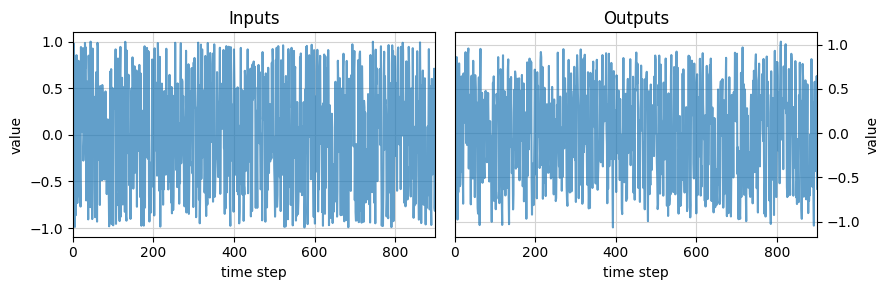

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
axes[0].plot(np.arange(1, X_train.shape[0]+1), X_train, alpha=0.7)
axes[1].plot(np.arange(1, y_train.shape[0]+1), y_train, alpha=0.7)
axes[0].set(xlabel='time step', ylabel='value', xlim=(0, X_train.shape[0]))
axes[1].set(xlabel='time step', ylabel='value', xlim=(0, y_train.shape[0]))
axes[0].set_title('Inputs')
axes[1].set_title('Outputs')
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()
for ax in axes.ravel().tolist():
    ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
fig.tight_layout()

## Model fitting and selection

We will use the polynomial NARX model $y_k = P_d(y_{k-1},\ldots,y_{k-n_y},u_{k-1},\ldots,u_{k-n_u}) + \epsilon_k$, where $P_d$ is a polynomial of degree $d$. Fitting and selection can be performed with the class `PolynomialNarmax`. A number of hyperparameters and options have to be set beforehand. For example, we choose a second-degree polynomial with maximum lag two in both the past inputs and past outputs.

In [6]:
model = FROLS(
    ylag=2,                              # max. lag of the output
    xlag=2,                              # max. lag of the input
    order_selection=True,                # whether to use an information criterion
    info_criteria='bic',                 # information criterion for model selection
    estimator='least_squares',           # parameter estimation method
    basis_function=Polynomial(degree=2)  # basis functions
)

/home/joseph/miniconda3/envs/nb/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


It is now time to perform parameter estimation and model order selection based on the training data. To that end, ordinary least squares (OLS) and the Bayesian information criterion (BIC) are used, respectively.

In [7]:
model.fit(X=X_train, y=y_train)

It is interesting to observe that the final model contains exactly the same terms as the process simulator. Moreover, the related coefficients are quite close to the actual parameter values. The estimation and selection procedures were successful in that regard. Sometimes, when a term in the selected model emerges that was not present in the original process, its estimated coefficient turns out to be comparably small.

In [8]:
results_df = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype='sci'
    ),
    columns=['Regressor', 'Coefficient', 'Error']
)

print(results_df)

       Regressor Coefficient           Error
0        x1(k-2)  9.0006E-01  9.55893238E-01
1         y(k-1)  1.9998E-01  4.07159324E-02
2  x1(k-1)y(k-1)  1.0003E-01  3.38728808E-03


When applied to the train or test data set, our trained model yields small mean squared errors.

In [9]:
y_pred_train = model.predict(X=X_train, y=y_train)
y_pred_test = model.predict(X=X_test, y=y_test)

mse_train = np.mean((y_train - y_pred_train)**2)
mse_test = np.mean((y_test - y_pred_test)**2)

print('MSE on train data: {:.4e}'.format(mse_train))
print('MSE on test data: {:.4e}'.format(mse_test))

MSE on train data: 1.0443e-06
MSE on test data: 1.2966e-06


Finally, we plot the test data and the corresponding model predictions. As expected, they are in very good visual agreement.

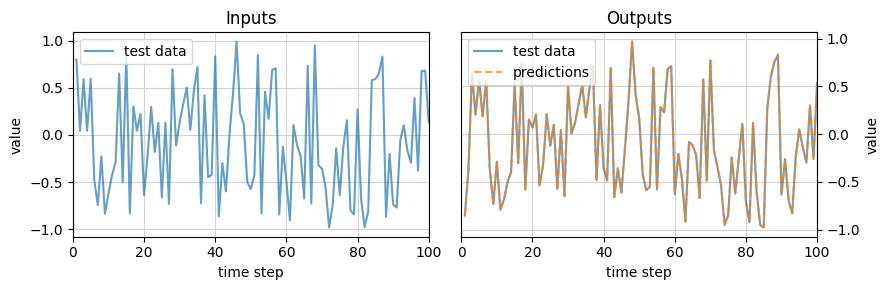

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
axes[0].plot(np.arange(1, X_test.shape[0]+1), X_test, alpha=0.7, label='test data')
axes[1].plot(np.arange(1, y_test.shape[0]+1), y_test, alpha=0.7, label='test data')
axes[1].plot(np.arange(1, y_pred_test.shape[0]+1), y_test, linestyle='--', alpha=0.7, label='predictions')
axes[0].set(xlabel='time step', ylabel='value', xlim=(0, X_test.shape[0]))
axes[1].set(xlabel='time step', ylabel='value', xlim=(0, y_test.shape[0]))
axes[0].set_title('Inputs')
axes[1].set_title('Outputs')
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
for ax in axes.ravel().tolist():
    ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
fig.tight_layout()